# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Data Preprocessing

### 2.1. Loading the data

In [26]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [27]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

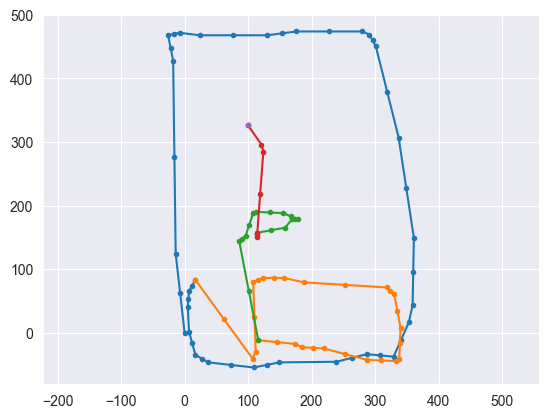

In [28]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [29]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    camera_labels = np.ones(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2
    calculator_labels = np.zeros(calculator_drawings.shape[0])

    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [31]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

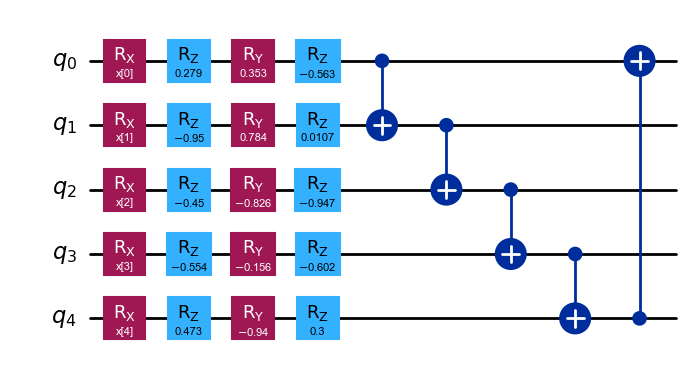

In [33]:
import random
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def generate_random_params(num_params, lower_bound=-1, upper_bound=1, seed=None):
    if seed is not None:
        random.seed(seed)
    return [random.uniform(lower_bound, upper_bound) for _ in range(num_params)]

def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    # Generar valores aleatorios para los parámetros del ansatz con una semilla
    fixed_params = generate_random_params(3 * n, seed=42)
    parameter_values = {param: value for param, value in zip(ansatz.parameters, fixed_params)}
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz.assign_parameters(parameter_values), inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN (
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=None,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool3(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [35]:
checkpoint_filepath = 'models/quantum_lstm_qfixed/best_model_weights_3classes.pth'

In [36]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 192/192 [03:54<00:00,  1.22s/it]


Epoch 1, Accuracy: 0.3351236979166667, Loss: 1.0996053876976173, Validation Accuracy: 0.326171875, Validation Loss: 1.0992673635482788


100%|██████████| 192/192 [04:08<00:00,  1.29s/it]


Epoch 2, Accuracy: 0.3323567708333333, Loss: 1.098871923983097, Validation Accuracy: 0.326171875, Validation Loss: 1.0989187955856323


100%|██████████| 192/192 [04:11<00:00,  1.31s/it]


Epoch 3, Accuracy: 0.3351236979166667, Loss: 1.0987008791416883, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:11<00:00,  1.31s/it]


Epoch 4, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:10<00:00,  1.31s/it]


Epoch 5, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:07<00:00,  1.29s/it]


Epoch 6, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:19<00:00,  1.35s/it]


Epoch 7, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:27<00:00,  1.40s/it]


Epoch 8, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:26<00:00,  1.39s/it]


Epoch 9, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:16<00:00,  1.34s/it]


Epoch 10, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:13<00:00,  1.32s/it]


Epoch 11, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:21<00:00,  1.36s/it]


Epoch 12, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:17<00:00,  1.34s/it]


Epoch 13, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:17<00:00,  1.34s/it]


Epoch 14, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:29<00:00,  1.40s/it]


Epoch 15, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:38<00:00,  1.45s/it]


Epoch 16, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:44<00:00,  1.48s/it]


Epoch 17, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:37<00:00,  1.44s/it]


Epoch 18, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:46<00:00,  1.49s/it]


Epoch 19, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:44<00:00,  1.48s/it]


Epoch 20, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:56<00:00,  1.54s/it]


Epoch 21, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:47<00:00,  1.50s/it]


Epoch 22, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:52<00:00,  1.52s/it]


Epoch 23, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 24, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:48<00:00,  1.50s/it]


Epoch 25, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:43<00:00,  1.48s/it]


Epoch 26, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:44<00:00,  1.48s/it]


Epoch 27, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:43<00:00,  1.48s/it]


Epoch 28, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 29, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:41<00:00,  1.46s/it]


Epoch 30, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:41<00:00,  1.47s/it]


Epoch 31, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:45<00:00,  1.49s/it]


Epoch 32, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:43<00:00,  1.48s/it]


Epoch 33, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:42<00:00,  1.47s/it]


Epoch 34, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:50<00:00,  1.51s/it]


Epoch 35, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:52<00:00,  1.52s/it]


Epoch 36, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:51<00:00,  1.52s/it]


Epoch 37, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:03<00:00,  1.58s/it]


Epoch 38, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:02<00:00,  1.57s/it]


Epoch 39, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:02<00:00,  1.58s/it]


Epoch 40, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:57<00:00,  1.55s/it]


Epoch 41, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:59<00:00,  1.56s/it]


Epoch 42, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:11<00:00,  1.62s/it]


Epoch 43, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:34<00:00,  1.74s/it]


Epoch 44, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:31<00:00,  1.73s/it]


Epoch 45, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:22<00:00,  1.68s/it]


Epoch 46, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:15<00:00,  1.64s/it]


Epoch 47, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:16<00:00,  1.65s/it]


Epoch 48, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:16<00:00,  1.65s/it]


Epoch 49, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:12<00:00,  1.63s/it]


Epoch 50, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:56<00:00,  1.54s/it]


Epoch 51, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:54<00:00,  1.53s/it]


Epoch 52, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:00<00:00,  1.56s/it]


Epoch 53, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:58<00:00,  1.55s/it]


Epoch 54, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:56<00:00,  1.55s/it]


Epoch 55, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:54<00:00,  1.54s/it]


Epoch 56, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:58<00:00,  1.55s/it]


Epoch 57, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:53<00:00,  1.53s/it]


Epoch 58, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:55<00:00,  1.54s/it]


Epoch 59, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:59<00:00,  1.56s/it]


Epoch 60, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:57<00:00,  1.55s/it]


Epoch 61, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:58<00:00,  1.55s/it]


Epoch 62, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:59<00:00,  1.56s/it]


Epoch 63, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:56<00:00,  1.54s/it]


Epoch 64, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [05:00<00:00,  1.57s/it]


Epoch 65, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:38<00:00,  1.45s/it]


Epoch 66, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:34<00:00,  1.43s/it]


Epoch 67, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:20<00:00,  1.35s/it]


Epoch 68, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:19<00:00,  1.35s/it]


Epoch 69, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:00<00:00,  1.25s/it]


Epoch 70, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:01<00:00,  1.26s/it]


Epoch 71, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:59<00:00,  1.25s/it]


Epoch 72, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:00<00:00,  1.25s/it]


Epoch 73, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:00<00:00,  1.25s/it]


Epoch 74, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [04:02<00:00,  1.27s/it]


Epoch 75, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:50<00:00,  1.20s/it]


Epoch 76, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:47<00:00,  1.18s/it]


Epoch 77, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:41<00:00,  1.15s/it]


Epoch 78, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:42<00:00,  1.16s/it]


Epoch 79, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:38<00:00,  1.14s/it]


Epoch 80, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:37<00:00,  1.13s/it]


Epoch 81, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:38<00:00,  1.14s/it]


Epoch 82, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:37<00:00,  1.13s/it]


Epoch 83, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:37<00:00,  1.13s/it]


Epoch 84, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:36<00:00,  1.13s/it]


Epoch 85, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:38<00:00,  1.14s/it]


Epoch 86, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:39<00:00,  1.14s/it]


Epoch 87, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:37<00:00,  1.13s/it]


Epoch 88, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:38<00:00,  1.14s/it]


Epoch 89, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:38<00:00,  1.14s/it]


Epoch 90, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:39<00:00,  1.14s/it]


Epoch 91, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:38<00:00,  1.14s/it]


Epoch 92, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:21<00:00,  1.05s/it]


Epoch 93, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:18<00:00,  1.03s/it]


Epoch 94, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:20<00:00,  1.05s/it]


Epoch 95, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:18<00:00,  1.03s/it]


Epoch 96, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:18<00:00,  1.03s/it]


Epoch 97, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:03<00:00,  1.05it/s]


Epoch 98, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:00<00:00,  1.06it/s]


Epoch 99, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


100%|██████████| 192/192 [03:00<00:00,  1.06it/s]


Epoch 100, Accuracy: 0.3351236979166667, Loss: 1.0986120700836182, Validation Accuracy: 0.326171875, Validation Loss: 1.098612666130066


## 5. Model Evaluation

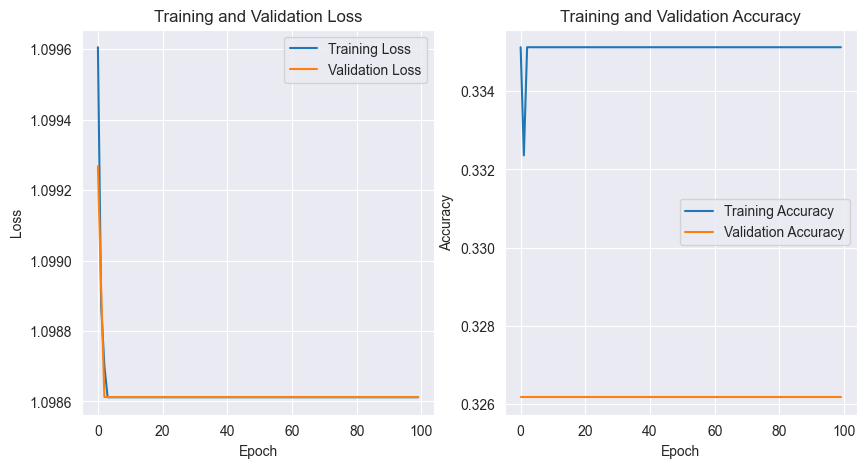

In [37]:
def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [38]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [39]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: calculator
True class: cell phone
